In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 361 (delta 108), reused 92 (delta 67), pack-reused 171
Receiving objects: 100% (361/361), 55.83 MiB | 43.27 MiB/s, done.
Resolving deltas: 100% (169/169), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./

In [ ]:
from dul_2021.utils.hw8_utils import *

In [ ]:
import numpy as np
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

from typing import Tuple, Union, List

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm.notebook import tqdm, trange

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


In [ ]:
class KMMDRE:
    def __init__(self, input_dim: int, hidden_dim: int = 128):
        self.sigma = 0.25
        self.input_dim = input_dim

        self.r = nn.Sequential(nn.Linear(input_dim, hidden_dim), 
                               nn.ReLU(),
                               nn.Linear(hidden_dim, hidden_dim), 
                               nn.ReLU(),
                               nn.Linear(hidden_dim, 1),
                               nn.Softplus())
    
    def fit(self, 
            data_nu: np.ndarray, data_de: np.ndarray, 
            batch_size: int = 512, lr: float = 1e-3, n_epochs: int = 100) -> "KMMDRE":
     
        loader_nu = data.DataLoader(data_nu, batch_size=batch_size, shuffle=True)
        loader_de = data.DataLoader(data_de, batch_size=batch_size, shuffle=True)
        
        optim = opt.Adam(self.r.parameters(), lr=lr)


        for epoch in trange(n_epochs, desc="Epoch"):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, self.input_dim).float()
                batch_de = batch_de.view(-1, self.input_dim).float()

                n_nu, n_de = batch_nu.shape[0], batch_de.shape[0]

                r_nu = torch.ones_like(batch_nu)
                r_de = self.r(batch_de)

                K_de_nu = self.get_kernel(batch_de, batch_nu)
                K_de_de = self.get_kernel(batch_de, batch_de)

                left = (r_de.T @ K_de_de @ r_de) / (n_de ** 2)
                right = 2 * (r_de.T @ K_de_nu @ r_nu) / (n_de * n_nu)

                loss = left - right

                optim.zero_grad()
                loss.backward()
                optim.step()
        
        return self

    def get_kernel(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        pow = (x ** 2).sum(axis=1).unsqueeze(1) - 2 * (x @ y.T) + (y ** 2).sum(axis=1).unsqueeze(0)
        pow /= -2 * self.sigma ** 2
        return pow.exp()

In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  # your code goes here

  # you need to calculate density ratio on x and return it
  # x = np.linspace(-2., 2, num=100)

  input_dim = 1
  model = KMMDRE(input_dim=input_dim).fit(data_nu, data_de)

  with torch.no_grad():
      x = np.linspace(-2., 2., num=100)        
      ratio_pred = model.r(torch.tensor(x.reshape(-1, input_dim), dtype=torch.float)).cpu().numpy()

  return ratio_pred

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

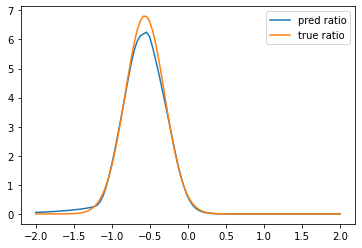

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class Discriminator(nn.Module): 
    def __init__(self, latent_dim: int, hidden_dim: int): 
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.layer_2 = nn.Sequential(
            nn.Linear(4 * 4 * 128 + latent_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor: 
        batch_size = len(x)
        out = self.layer_1(x).view(batch_size, -1)
        out = torch.cat((out, z), dim=1)
        out = self.layer_2(out)
        return out


class Encoder(nn.Module): 
    def __init__(self, noise_dim: int, latent_dim: int): 
        super().__init__()
        self.noise_dim = noise_dim

        self.layer_1 = nn.Sequential( 
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.layer_2 = nn.Linear(4 * 4 * 128 + noise_dim, latent_dim)

        self.noise_distr = Normal(torch.tensor(0.0).to(device), 
                                  torch.tensor(1.0).to(device))

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = len(x)
        out = self.layer_1(x).view(batch_size, -1)
        z = self.noise_distr.sample((batch_size, self.noise_dim)).squeeze()
        out = torch.cat((out, z), dim=1)
        out = self.layer_2(out)
        return out


class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128), 
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layer_1(x)
        out = out.view(-1, 128, 4, 4)
        out = self.layer_2(out)
        return out

In [ ]:
class AVB(nn.Module):
    def __init__(self, noise_dim: int, latent_dim: int, hidden_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        self.disc = Discriminator(latent_dim, hidden_dim).to(device)
        self.enc = Encoder(noise_dim, latent_dim).to(device)
        self.dec = Decoder(latent_dim).to(device)

        self.prior = Normal(torch.tensor(0.0).to(device), 
                            torch.tensor(1.0).to(device))

    # def disc_loss(self, x: torch.Tensor) -> torch.Tensor: 
    #     z_p = self.prior.sample((len(x), self.latent_dim)).squeeze()
    #     z_q = self.enc(x)
          
    #     log_d_prior = self.disc(x, z_p)
    #     log_d_posterior = self.disc(x, z_q)

    #     # disc_loss = torch.mean(
    #     #     F.binary_cross_entropy_with_logits(log_d_posterior, torch.ones_like(log_d_posterior))
    #     #     + F.binary_cross_entropy_with_logits(log_d_prior, torch.zeros_like(log_d_prior)))
          
    #     return disc_loss

    def clf_loss(self, x: torch.Tensor, z_q: torch.Tensor) -> torch.Tensor: 
        z_p = self.prior.sample((x.shape[0], self.latent_dim)).squeeze() 
        prior_loss = -torch.log(1 - torch.sigmoid(self.disc(x, z_p))).mean()
        posterior_loss = -torch.log(torch.sigmoid(self.disc(x, z_q))).mean()
        loss = prior_loss + posterior_loss
        return loss

    def elbo_loss(self, x: torch.Tensor, z_q: torch.Tensor) -> torch.Tensor: 
        disc_loss = self.disc(x, z_q).mean()
        x_recon = self.dec(z_q)
        log_p_posterior_loss = ((x - x_recon) ** 2).mean()
        loss = disc_loss + log_p_posterior_loss
        return loss

    # def gen_loss(self, x: torch.Tensor) -> torch.Tensor: 
    #     z_q = self.enc(x)
    #     log_d_posterior = self.disc(x, z_q)
    #     x_recon = self.dec(z_q)
    #     recon_likelihood = -F.binary_cross_entropy(x_recon, x) * len(x)
    #     gen_loss = torch.mean(log_d_posterior) - torch.mean(recon_likelihood)
          
    #     return gen_loss

    def test(self, test_loader: data.DataLoader) -> Tuple[List[float], List[float]]:
        test_elbo, test_clf = [], []

        with torch.no_grad():
            self.eval()
            for x in test_loader:
                x = x.float().to(device)
                z_q = self.enc(x)
                elbo_loss = self.elbo_loss(x, z_q)
                clf_loss = self.clf_loss(x, z_q)

                test_elbo.append(elbo_loss.item())
                test_clf.append(clf_loss.item())
                        
        return test_elbo, test_clf

    def fit(self, 
            train_data: np.ndarray,
            test_data: np.ndarray, 
            lr: float = 1e-3, 
            n_epochs: int = 100, 
            batch_size: int = 128) -> Tuple[np.ndarray, ...]:
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size=batch_size)

        gen_opt = opt.Adam(list(self.enc.parameters()) + list(self.dec.parameters()), lr=lr)
        dis_opt = opt.Adam(self.disc.parameters(), lr=lr)

        train_elbo, train_clf = [], []
        test_elbo, test_clf = [], []

        for epoch in trange(n_epochs, desc="Epoch"):
            self.train()
            for x in tqdm(train_loader, desc="Train batch", leave=False): 
                x = x.float().to(device)
                z_q = self.enc(x)

                clf_loss = self.clf_loss(x.detach(), z_q.detach())
                dis_opt.zero_grad()
                clf_loss.backward()
                dis_opt.step()
                train_clf.append(clf_loss.item())
                
                elbo_loss = self.elbo_loss(x, z_q)
                gen_opt.zero_grad()
                elbo_loss.backward()
                gen_opt.step()
                train_elbo.append(elbo_loss.item())

            elbo_losses, clf_losses = self.test(test_loader)
            test_elbo.extend(elbo_losses)
            test_clf.extend(clf_losses)

        return np.array(train_elbo), np.array(train_clf), np.array(test_elbo), np.array(test_clf)

    def sample(self, n_samples: int = 100) -> np.ndarray:
        self.eval()
        with torch.no_grad():
            z = self.prior.sample((n_samples, self.latent_dim))
            x = self.dec(z)
        return x.cpu().numpy()

In [ ]:
def transform(x: np.ndarray) -> np.ndarray: 
    # {0, 1} -> [-1, 1]
    return 2 * x.astype(np.float32) - 1

def inv_transform(x: np.ndarray) -> np.ndarray: 
    # [-1, 1] -> [0, 1]
    return 0.5 * x + 0.5

In [ ]:
def q2(train_data: np.ndarray, test_data: np.ndarray):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    train_data_tr = transform(train_data.transpose(0, 3, 1, 2))
    train_data = torch.tensor(train_data_tr).to(device)

    test_data_tr = transform(test_data.transpose(0, 3, 1, 2))
    test_data = torch.tensor(test_data_tr).to(device)

    model = AVB(noise_dim=64, latent_dim=64, hidden_dim=64).to(device)
    train_elbo, train_clf, test_elbo, test_clf = model.fit(train_data, test_data,
                                                           n_epochs=25, batch_size=128)
    samples = inv_transform(model.sample(100))

    return train_elbo, train_clf, test_elbo, test_clf, samples

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

Train batch:   0%|          | 0/469 [00:00<?, ?it/s]

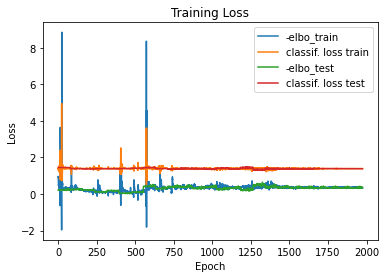

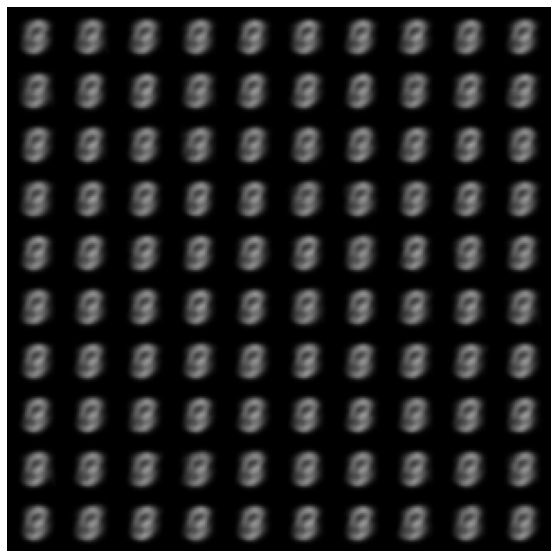

In [ ]:
q2_results(q2)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

Train batch:   0%|          | 0/235 [00:00<?, ?it/s]

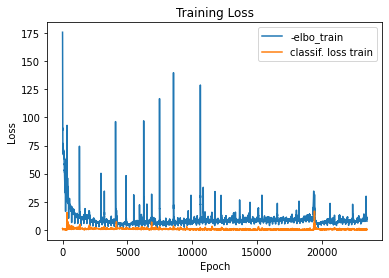

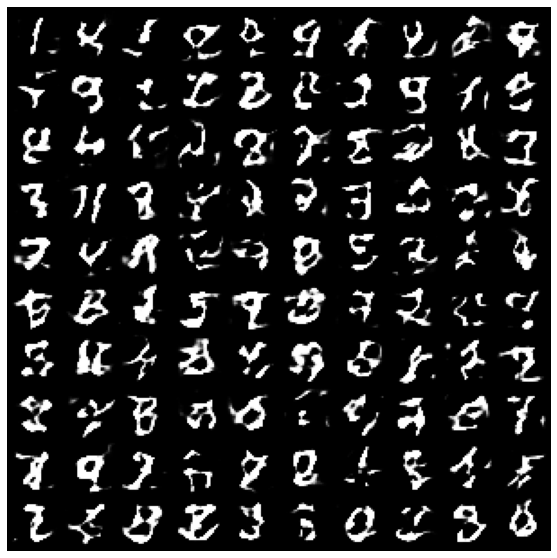

In [ ]:
q2_results(q2)